In [38]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from data_preprocesser import preprocessed_data_path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [39]:
df = pd.read_csv(preprocessed_data_path + 'categories_30000/yelp_academic_dataset_review_Auto Repair.csv')
df.head()

,review_id,business_id,stars_x,stars_y,date,city,text,categories
0,JN0tmjiksWfr4i2NIFuPXw,pLZ9oZM8c6MNbRlg06lBPg,1,3.0,2016-08-03,Las Vegas,THEY SELL WRECKED VEHICLES! \nI purchased a 20...,Auto Repair;Car Dealers;Automotive;Auto Parts ...
1,lFmz61DNRzBPnrwH_cF42g,J0KZR0DDnvj73D-xmbh4uA,4,4.0,2017-06-15,Las Vegas,I stopped in here recently as I had to buy a t...,Auto Parts & Supplies;Auto Repair;Automotive
2,R9p3ug8zNPvawYX_jsO0UA,Tknj3u-3CZTI-q52saTAIA,1,1.0,2012-09-12,Toronto,"If you want the ""I don't give a shit "" attitud...",Car Dealers;Auto Repair;Automotive
3,FMXER_6R6URYBpV6TYPn9A,rV1nkTx58v_q7YGDkGzfxQ,5,5.0,2016-06-10,Las Vegas,where to start...\na few months ago I slammed....,Auto Repair;Automotive
4,bJN2ZPa0jF4xgR1gPKZP3A,hCXknMQalY1QQZrdZGuBHg,3,3.5,2017-01-24,Las Vegas,I have mixed feelings here. I recently purchas...,Car Dealers;Auto Repair;Automotive


In [40]:
# Processing Functions
def identify_tokens(row):
    review = row['text']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    # token_words = [re.sub("[^\w\s]", " ", w) for w in tokens]
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops and w != " "]
    return (meaningful_words)

stemming = PorterStemmer()

def stem_list(row):
    my_list = row['words_meaningful']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

lemming = WordNetLemmatizer()

def lem_list(row):
    my_list = row['words_non_stop']
    lemmed_list = [lemming.lemmatize(word) for word in my_list]
    return (lemmed_list)

def rejoin_words(row):
    my_list = row['words_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

In [41]:
def process(data_df):
    data_df['text'] = data_df['text'].str.lower()
    data_df['words'] = data_df.apply(identify_tokens, axis=1)
    data_df['words_non_stop'] = data_df.apply(remove_stops, axis=1)
    data_df['words_meaningful'] = data_df.apply(lem_list, axis=1)
    data_df['processed'] = data_df.apply(rejoin_words, axis=1)
    return data_df

In [42]:
df_processed = process(df)

In [43]:
text = " ".join(review for review in df['processed'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 11509080 words in the combination of all review.


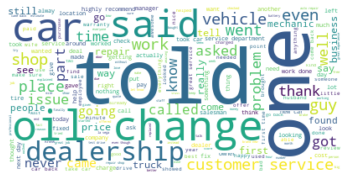

In [44]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# GENSIM LDA

In [45]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [46]:
# Create Dictionary
id2word = corpora.Dictionary(df_processed['words_meaningful'])
print('Mots uniques dans les textes initiaux:', len(id2word))

# On filter out les mots qui appraraissent dans moins de 2 textes ou dans plus de 50% des textes
id2word.filter_extremes(no_below=2, no_above=0.5)
print('Mots uniques après suppression des mots trop fréquents ou trop rares:', len(id2word))

# Create Corpus
texts = df_processed['words_meaningful']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Mots uniques dans les textes initiaux: 27955
Mots uniques après suppression des mots trop fréquents ou trop rares: 15392


In [47]:
# Build LDA model
%time lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

CPU times: user 1min 25s, sys: 10.3 ms, total: 1min 25s
Wall time: 1min 25s


In [48]:
for (i,topic) in enumerate(lda_model.print_topics()):
    print(f'Top 10 des mots pour le topic #{i}:')
    print([i for i in topic[1].split('"') if str(i).isalpha()])
    print('\n')

Top 10 des mots pour le topic #0:
['dealership', 'u', 'sale', 'vehicle', 'experience', 'deal', 'new', 'price', 'wanted', 'buy']


Top 10 des mots pour le topic #1:
['oil', 'change', 'problem', 'part', 'issue', 'took', 'brake', 'fix', 'mechanic', 'fixed']


Top 10 des mots pour le topic #2:
['would', 'back', 'told', 'get', 'said', 'day', 'could', 'hour', 'called', 'call']


Top 10 des mots pour le topic #3:
['service', 'great', 'work', 'tire', 'shop', 'repair', 'done', 'price', 'recommend', 'always']


Top 10 des mots pour le topic #4:
['time', 'customer', 'guy', 'like', 'go', 'service', 'get', 'know', 'place', 'even']




In [49]:
coherencemodel = CoherenceModel(model=lda_model, texts=df_processed['words_meaningful'], dictionary=id2word, coherence='c_v')
print("Coherence score : " + str(coherencemodel.get_coherence()))

Coherence score : 0.43950610122088607


# GENSIM LDA MALLET

In [13]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Il faut java ! 
# !! Changer le path ci dessous !!
mallet_path = '/home/arthur/mallet-2.0.8/bin/mallet' 
%time ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

CPU times: user 4.38 s, sys: 40 ms, total: 4.42 s
Wall time: 1min 12s


In [14]:
for (i,topic) in enumerate(ldamallet.print_topics()):
    print(f'Top 10 des mots pour le topic #{i}:')
    print([i for i in topic[1].split('"') if str(i).isalpha()])
    print('\n')

Top 10 des mots pour le topic #0:
['problem', 'part', 'issue', 'repair', 'needed', 'shop', 'mechanic', 'brake', 'fixed', 'back']


Top 10 des mots pour le topic #1:
['service', 'time', 'oil', 'tire', 'change', 'place', 'hour', 'guy', 'customer', 'minute']


Top 10 des mots pour le topic #2:
['told', 'day', 'back', 'called', 'call', 'asked', 'time', 'manager', 'week', 'give']


Top 10 des mots pour le topic #3:
['great', 'work', 'service', 'recommend', 'honest', 'shop', 'friendly', 'auto', 'job', 'guy']


Top 10 des mots pour le topic #4:
['dealership', 'vehicle', 'experience', 'price', 'sale', 'deal', 'wanted', 'made', 'dealer', 'buy']




In [16]:
coherencemodel = CoherenceModel(model=ldamallet, texts=df_processed['words_meaningful'], dictionary=id2word, coherence='c_v')
print("Coherence score : " + str(coherencemodel.get_coherence()))

Coherence score : 0.4339798358940207


# Test viz

In [53]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [54]:
#ldamallet_transformed = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.247021  0.025158       1        1  30.215498
2     -0.225310  0.041248       2        1  28.215500
3      0.072447 -0.244783       3        1  16.690928
1      0.205097 -0.145815       4        1  13.219100
0      0.194786  0.324193       5        1  11.658974, topic_info=    Category          Freq        Term         Total  loglift  logprob
94   Default  23174.000000     service  23174.000000  30.0000  30.0000
260  Default  10984.000000       great  10984.000000  29.0000  29.0000
602  Default   8808.000000         oil   8808.000000  28.0000  28.0000
16   Default   8152.000000  dealership   8152.000000  27.0000  27.0000
239  Default  11740.000000        work  11740.000000  26.0000  26.0000
..       ...           ...         ...           ...      ...      ...
138   Topic5   1403.295654       drive   3381.446777   1.2696  -4.9514
66    Topic5   1302.614136    warranty   2982.448975   1.3207  -5.0259
857   Topic5   1229.765259        used   2789.730469   1.3300  -5.0834
398   Topic5    978.549316       offer   1344.141357   1.8317  -5.3119
175   Topic5   1157.259155        made   4188.904785   0.8627  -5.1442

[289 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.999604  absolutely
1288      4  0.997895          ac
103       3  0.999370   alignment
106       1  0.250905        also
106       2  0.093568        also
...     ...       ...         ...
242       2  0.317146       wrong
242       4  0.682618       wrong
69        1  0.929080        year
69        3  0.026465        year
69        4  0.044357        year

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus, 
    texts=df_processed['words_meaningful'], 
    start=2, 
    limit=10, 
    step=1)

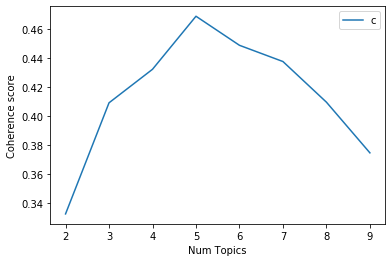

In [41]:
limit=10
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# GENSIM HDP

In [10]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
import gensim.corpora as corpora

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(df_processed['words_meaningful'])
print('Mots uniques dans les textes initiaux:', len(id2word))

# On filter out les mots qui appraraissent dans moins de 2 textes ou dans plus de 50% des textes
id2word.filter_extremes(no_below=2, no_above=0.5)
print('Mots uniques après suppression des mots trop fréquents ou trop rares:', len(id2word))

# Create Corpus
texts = df_processed['words_meaningful']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Mots uniques dans les textes initiaux: 27955
Mots uniques après suppression des mots trop fréquents ou trop rares: 15392


In [12]:
%time hdp = HdpModel(corpus, id2word)

CPU times: user 7min 18s, sys: 5 s, total: 7min 23s
Wall time: 1min 51s


In [20]:
id2word

In [17]:
hdp.show_topics()

[(0,
  '0.012*service + 0.010*would + 0.009*get + 0.008*back + 0.008*time + 0.007*told + 0.006*work + 0.006*said + 0.006*one + 0.005*could + 0.005*day + 0.005*vehicle + 0.005*new + 0.005*go + 0.005*tire + 0.005*oil + 0.005*dealership + 0.005*shop + 0.005*even + 0.005*customer'),
 (1,
  '0.013*service + 0.009*would + 0.008*get + 0.008*time + 0.007*back + 0.006*work + 0.006*told + 0.006*vehicle + 0.006*dealership + 0.006*new + 0.005*great + 0.005*one + 0.005*customer + 0.005*could + 0.005*go + 0.005*day + 0.005*said + 0.005*experience + 0.005*price + 0.004*guy'),
 (2,
  '0.015*service + 0.008*time + 0.008*would + 0.008*get + 0.007*great + 0.007*work + 0.006*back + 0.006*place + 0.005*customer + 0.005*shop + 0.005*price + 0.005*guy + 0.005*vehicle + 0.005*repair + 0.005*new + 0.005*oil + 0.005*go + 0.005*tire + 0.005*done + 0.005*one'),
 (3,
  '0.015*service + 0.009*great + 0.008*time + 0.008*work + 0.007*get + 0.007*would + 0.006*back + 0.006*place + 0.006*shop + 0.005*price + 0.005*repa

# LSI & LDA

In [33]:
import gensim
import operator

In [34]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = gensim.models.CoherenceModel(topics=[topic], texts=df_processed['words_meaningful'].tolist(), dictionary=id2word, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [35]:
lm, top_topics = ret_top_model()

Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/arthur/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/arthur/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/arthur/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/arthur/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/arthur/anaconda3/envs/py36/lib/python3

KeyboardInterrupt: 